# Monte Carlo Markov Chains para CMB

Agora que vimos os conceitos básicos de MCMC e análise estatística, é a sua vez. A Gabriela gerou dados observacionais da temperatura de CMB, enquanto o Guilherme explicou como fornecer previsões teóricas. O objetivo é obter intervalos de confiança para dois parâmetros cosmológicos, $\Omega_m$ e $\sigma_8$, e gerar um corner plot para ambos.

Vou deixar vocês com um código base, copiado da Gabriela e do Guilherme.

Me chamem se tiverem qualquer dúvida ou problema!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

In [8]:
def get_cmb_cl(Omega_m, sigma_8):
    params = {
        # -------------------- SAÍDAS --------------------
        'modes'  : 's',
        'output' : 'tCl, pCl, lCl',
        'lensing': 'yes',
        'l_max_scalars': 2500,

        # ----------------- COSMOLOGIA -------------------
        # DE como fld (Ω_Λ=0 e w0/wa dados)
        'Omega_Lambda': 0,
        'w0_fld'      : '-1.',
        'wa_fld'      : '0.0',

        # Primordial
        'sigma8': sigma_8,
        'n_s'   : 0.96,

        # Verbosidade/Gauge
        'background_verbose'   : 0,
        'perturbations_verbose': 0,
        'gauge'                : 'Synchronous',

        # Fundo
        'h'        : 0.673,
        'Omega_b'  : 0.05,
        'Omega_cdm': Omega_m - 0.05,  # valor fiducial
        'Omega_k'  : 0.0,
    }
    M = Class(); M.set(params); M.compute()
    lensed = M.lensed_cl(2500)   
    ell   = np.asarray(lensed['ell'])
    clTT  = np.asarray(lensed['tt'])
    return ell, clTT

In [9]:
# Dados observacionais
data_clTT = np.array([2.60553702e-12, 2.02788402e-12, 1.06423433e-12, 1.09773609e-12,
       6.86447452e-13, 6.64750665e-13, 4.83504357e-13, 3.94839786e-13,
       2.53850938e-13, 1.22401972e-13, 3.65252749e-14, 2.31454934e-14,
       1.26393137e-14, 7.03466801e-15, 2.64865318e-15, 1.05617902e-15,
       3.44741822e-16, 8.88152228e-17, 2.46245051e-17, 7.77417404e-18])
data_ell = np.array([  34.18020275,   43.70554792,   55.88541803,   71.45957658,
         91.37394449,  116.83805209,  149.39850188,  191.03290378,
        244.26998844,  312.34319361,  399.38705209,  510.68830901,
        653.00702063,  834.98713689, 1067.68150534, 1365.22318305,
       1745.68383008, 2232.17132   , 2854.23323282, 3649.6514736 ])

Text(0, 0.5, 'C_\\ell^{TT}')

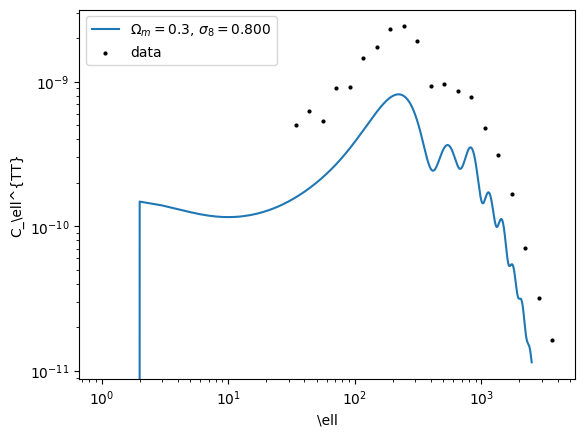

In [12]:
# Exemplo de cosmologia
# NOTE: o fator ell*(ell+1)/(2*pi) é apenas para fins de visualização
ell, clTT = get_cmb_cl(Omega_m=0.3, sigma_8=0.800)
plt.loglog(ell, ell*(ell+1)*clTT/(2*np.pi), label=f"$\\Omega_m = 0.3$, $\\sigma_8 = 0.800$")
plt.scatter(data_ell, data_ell*(data_ell+1)*data_clTT/(2*np.pi), s=4, color="black", label="data")
plt.legend()
plt.xlabel("\\ell")
plt.ylabel("C_\\ell^{TT}")